# Reconstructing a food web using FishBase data

We will focus on teleost fish, class _Actinopterygii_, and elasmobranchs, class _Elasmobranchii_. We will use the FishBase database to reconstruct a food web of these two classes. We will use the `rfishbase` R package to access the FishBase database.

In [1]:
%load_ext rpy2.ipython

## Extract fish species for the Galapagos POC

From: 

1. https://github.com/leholman/GalapeDNA
2. https://www.biorxiv.org/content/10.1101/2024.03.06.583537v1.full

In [2]:
import pandas as pd

df = pd.read_csv('leholman/taxonomy.csv')
fish = df[df["B.class"].isin(["Actinopteri", "Chondrichthyes"])]

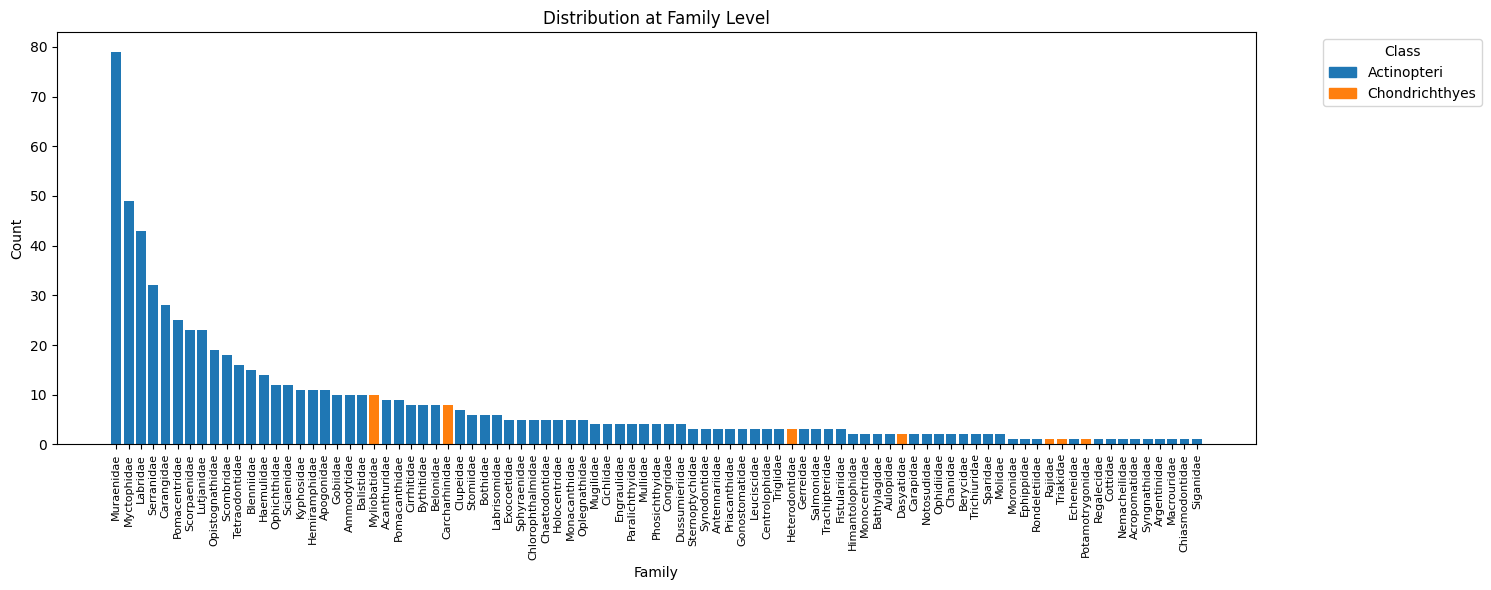

In [3]:
from src.helpers import plot_family_distribution

plot_family_distribution(fish)

In [4]:
fish_result = (fish[['ID', 'B.class', 'B.family', 'B.species']]
               .dropna(subset=['B.class', 'B.family', 'B.species'], how='all')
               .dropna(subset=['B.species'], how='all')
               .groupby(['B.class', 'B.family', 'B.species'])['ID'].agg(','.join).reset_index())

fish_result.to_csv('outputs/galapagos_fish_taxonomy.csv', index=False)

## Reconstruct food web with FishBase data

In [4]:
%%R

source("src/helpers.R")

input_file <- "outputs/galapagos_fish_taxonomy.csv"
output_file <- "outputs/galapagos_trophic_info.csv"

main(input_file, output_file)

Rows: 168 Columns: 4


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): B.class, B.family, B.species, ID

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(SpecCode)`
Joining with `by = join_by(SpecCode)`
[1] "Output saved to outputs/galapagos_trophic_info.csv"


These are the stations that were sampled in the Galapagos dataset:

In [1]:
import pandas as pd
station_meta = pd.read_csv(
    'leholman/metadata.site.out.csv',
    usecols=lambda x: x != 'Unnamed: 0'
    ).set_index("SiteID")
station_meta.head()

,Location,island,latitude,longitude,EcoRegion,SamplingDate,DeepSampleDepthFeet,ShallowSampleDepthFeet,lat2,lon2
SiteID,,,,,,,,,,
BAR,Barahona Beach,Isabela,"S 01º02,325´","W 091º 09,382´",Western,30/09/2018,12.0,6,-1.038750,-91.156367
CDOU,Cabo Douglas,Fernandina,"S 00º18,169´","W 091º 39,104´",Western,03/10/2018,12.0,3,-0.302817,-91.651733
CHAM,Cabo Hammond,Fernandina,"S 00º28,175´","W 091º 36,671´",Western,02/10/2018,18.0,3,-0.469583,-91.611183
CMAR,Cabo Marshall,Isabela,"S 00º00,080´","W 091º 13,431´",CSouthEastern,05/10/2018,17.8,3,-0.001333,-91.223850
CORA,Salvaje de Corazón,Genovesa,"N 00º18,679´","W 089º 58,509´",Northern,08/10/2018,18.0,3,0.311317,-89.975150


## Adding extra fields to FishBase's diet table

We will add broader prey categories to the diet table, as well as average trophic levels for these aggregated categories. We will also add Station IDs in the Galapagos dataset from where each fish species have been found.


In [2]:
from src.helpers import add_station_to_trophic_info, add_prey_categories_to_trophic_info

station_file = "leholman/Cleaned_Master_wTAX.csv"
trophic_file = "outputs/galapagos_trophic_info.csv"
food_categories = "outputs/trophic_levels.json"
output_file = "outputs/galapagos_trophic_info_with_station.csv"
output_file_avg = "outputs/galapagos_trophic_info_with_station_avg.csv"

add_station_to_trophic_info(station_file, trophic_file, output_file, station_meta.index.tolist())
add_prey_categories_to_trophic_info(output_file, food_categories, output_file_avg)

Updated trophic data saved to outputs/galapagos_trophic_info_with_station.csv
Updated CSV saved to outputs/galapagos_trophic_info_with_station_avg.csv


## Build food webs for the entire Galapagos dataset

Let's first build the food web for the entire Galapagos dataset, so all locations pooled together.

In [4]:
from src.helpers import build_trophic_web, save_graph, add_asv_ids_to_graph_data

station_id = "ALL"
G = build_trophic_web(
    'outputs/galapagos_trophic_info_with_station_avg.csv',
    station_id=None,
    )

save_graph(G, f'outputs/trophic_webs/galapagos_trophic_web_{station_id}.tsv')
add_asv_ids_to_graph_data(
    f'outputs/trophic_webs/galapagos_trophic_web_{station_id}.tsv',
    f'outputs/galapagos_trophic_info_with_station_avg.csv',
    f'outputs/trophic_webs/galapagos_trophic_web_{station_id}.tsv',
    )

/home/robaina/miniconda3/envs/fishbase/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(
/home/robaina/Documents/NewAtlantis/galapagos_poc/fishbase/src/helpers.py:411: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


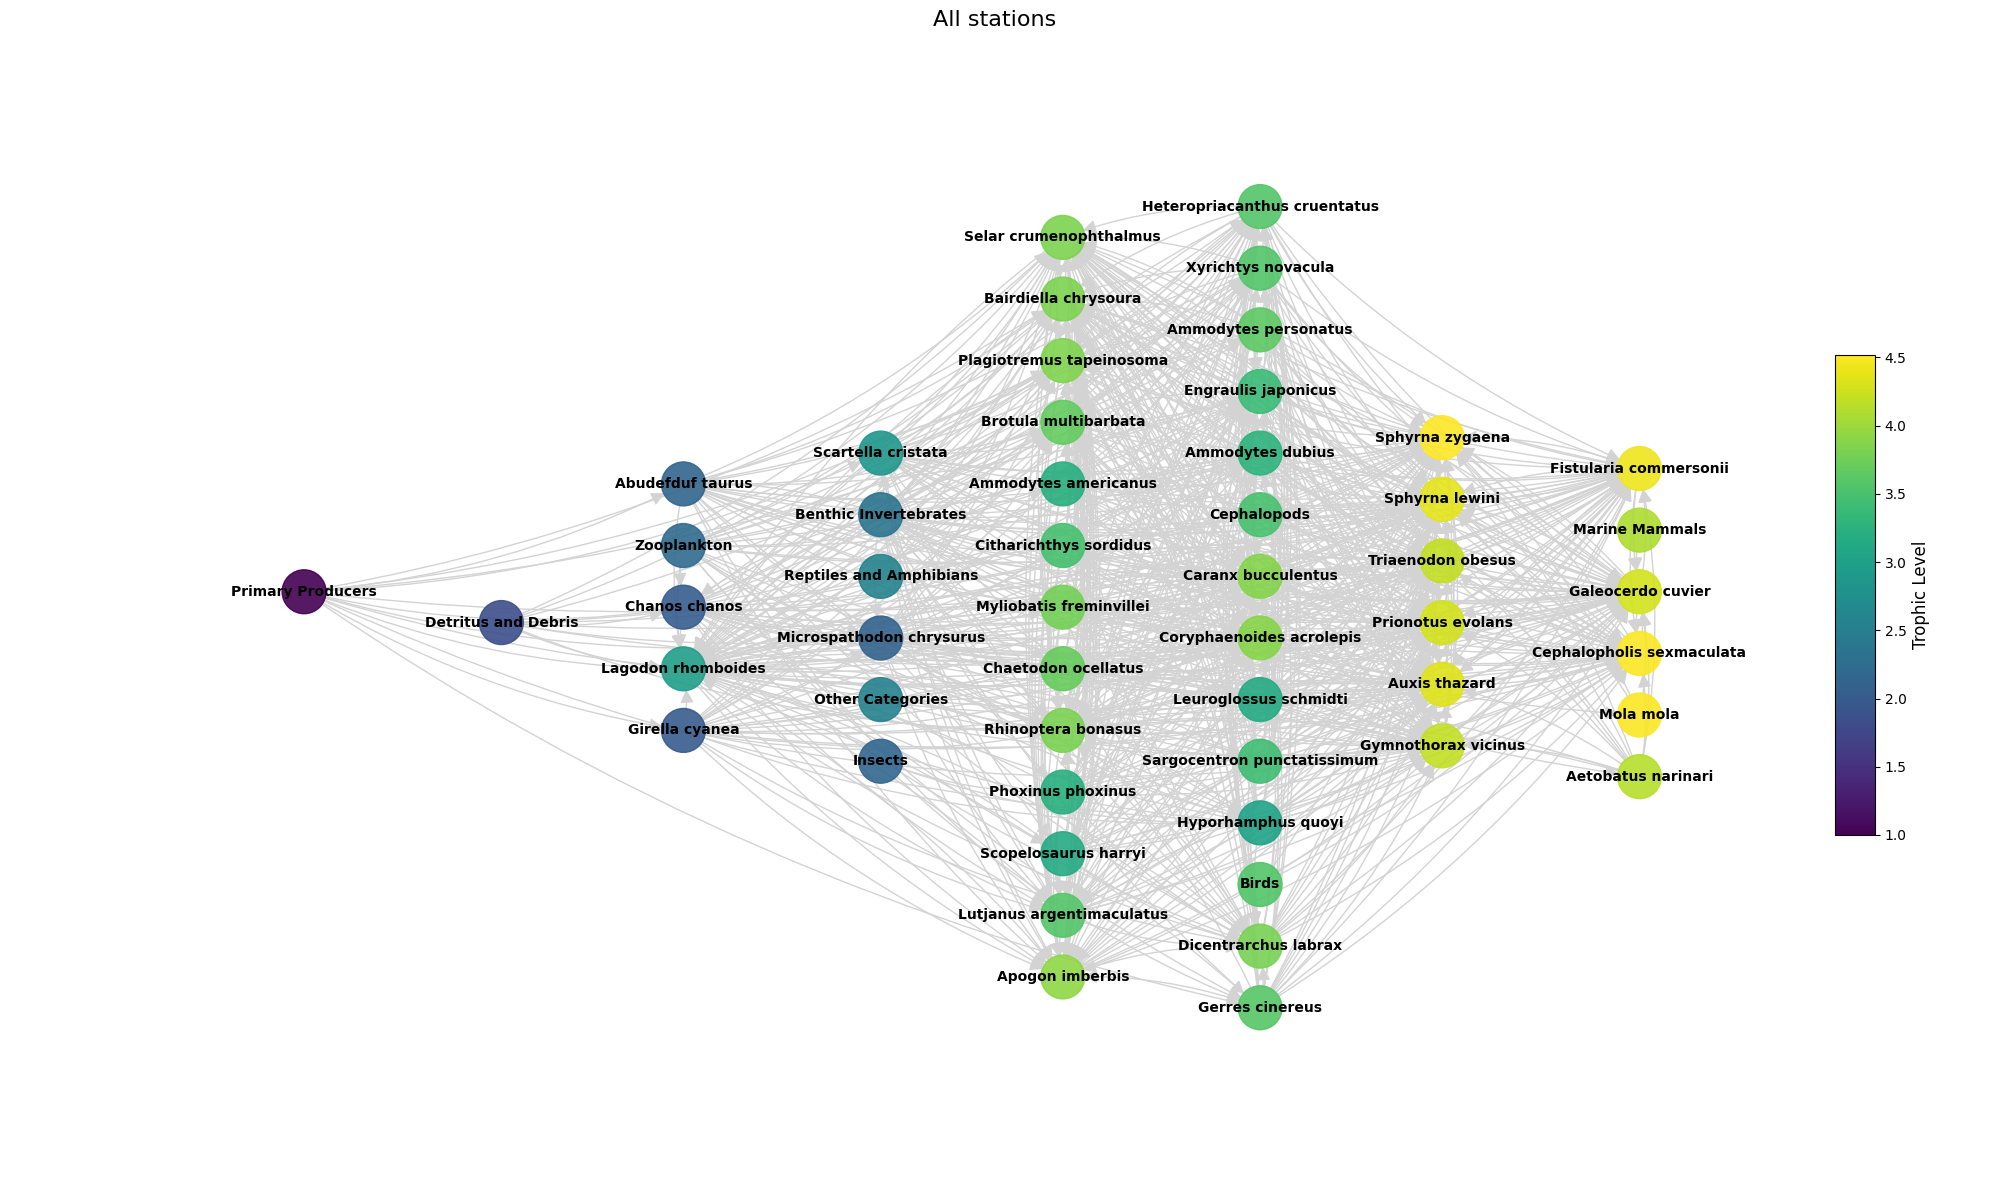

In [5]:
from src.helpers import visualize_trophic_web_horizontal, build_trophic_web

station_id = "ALL"
G = build_trophic_web(
    'outputs/galapagos_trophic_info_with_station_avg.csv',
    station_id=None,
    )
visualize_trophic_web_horizontal(
    G,
    title=f"All stations",
    figsize=(20, 12),
    node_size=1000,
    node_margin=15,
    colorbar=True,
    figure_file=f'outputs/trophic_webs/galapagos_trophic_web_{station_id}.png',
    no_figure=False,
    )

## Build food webs for each station

We will next build a food web for each station in the Galapagos dataset.

In [2]:
from src.helpers import build_trophic_web, save_graph, add_asv_ids_to_graph_data

for station_id in station_meta.index:
    G = build_trophic_web(
        'outputs/galapagos_trophic_info_with_station_avg.csv',
        station_id=station_id
        )

    save_graph(G, f'outputs/trophic_webs/galapagos_trophic_web_{station_id}.tsv')
    add_asv_ids_to_graph_data(
        f'outputs/trophic_webs/galapagos_trophic_web_{station_id}.tsv',
        f'outputs/galapagos_trophic_info_with_station_avg.csv',
        f'outputs/trophic_webs/galapagos_trophic_web_{station_id}.tsv',
        )

In [6]:
from src.helpers import visualize_trophic_web, build_trophic_web

for station_id in station_meta.index:
    station_name = station_meta.loc[station_id, "Location"]
    G = build_trophic_web(
        'outputs/galapagos_trophic_info_with_station_avg.csv',
        station_id=station_id
        )
    visualize_trophic_web(
        G,
        title=f"{station_name} ({station_id})",
        figsize=(10, 8),
        node_size=2000,
        node_margin=25,
        colorbar=True,
        figure_file=f'outputs/trophic_webs/galapagos_trophic_web_{station_id}.png',
        no_figure=True,
        )

Let's display the reconstructed food web for station __Barahona Beach__ on Isabella Island, nodes are colored by estimated trophic level (obtained from FishBase):

<div style="width:100%;text-align:center;">
    <img src="outputs/trophic_webs/galapagos_trophic_web_BAR.png" alt="Barahona Beach" width="500">
</div>

## Plot distribution of trophic levels

Let's next plot the distribution of trophic levels for the fish species in the food web across the entire dataset and for each sampling site in Galapagos.

Plot saved to outputs/trophic_level_distributions/galapagos_trophic_distribution_ALL.png


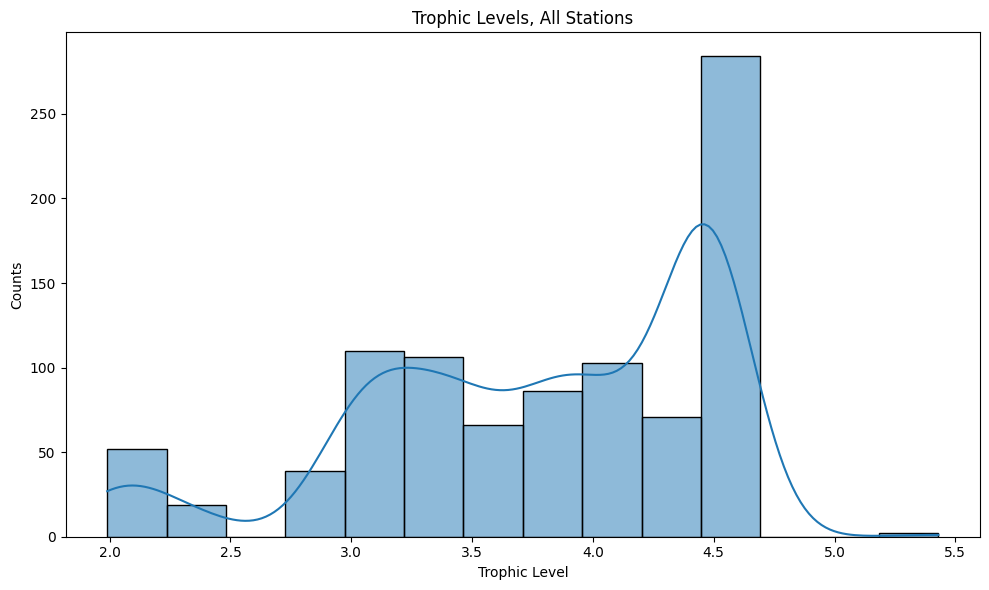

In [18]:
import pandas as pd
from src.helpers import plot_trophic_level_distribution

trophic = pd.read_csv('outputs/galapagos_trophic_info_with_station_avg.csv')
trophic = trophic.dropna(subset=['Troph'])

station_id = "ALL"
plot_trophic_level_distribution(
    trophic,
    station_ids=None,
    title=f"Trophic Levels, All Stations",
    output_file=f"outputs/trophic_level_distributions/galapagos_trophic_distribution_{station_id}.png",
    no_figure=False,
    )

In [3]:
import pandas as pd
from src.helpers import plot_trophic_level_distribution

trophic = pd.read_csv('outputs/galapagos_trophic_info_with_station_avg.csv')
trophic = trophic.dropna(subset=['Troph'])

for station_id in station_meta.index:
    plot_trophic_level_distribution(
        trophic,
        station_ids=[station_id],
        title=f"Trophic Levels, {station_meta.loc[station_id, "Location"]} ({station_id})",
        output_file=f"outputs/trophic_level_distributions/galapagos_trophic_distribution_{station_id}.png",
        no_figure=True,
        )

Let's plot the distribution of trophic levels for the fish species in the food web of Barahona Beach:

<div style="width:100%;text-align:center;">
    <img src="outputs/trophic_level_distributions/galapagos_trophic_distribution_BAR.png" alt="Barahona Beach" width="500">
</div>

## Investigating the correlation between trophic level and body size

The correlation between Trophic Level and Log(Body Length) is: 0.7064305833466327


/tmp/ipykernel_40959/4196690625.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['Log_Length'] = np.log(data_cleaned['Length'])


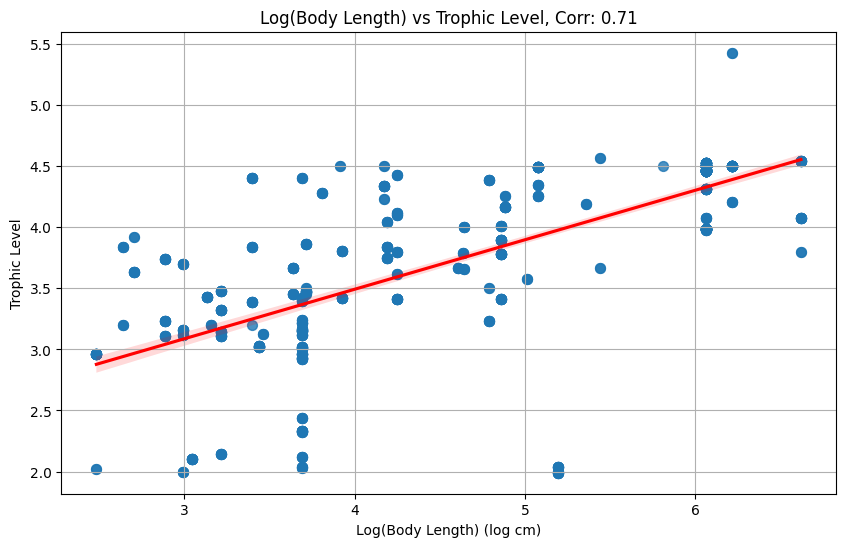

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


data = pd.read_csv('outputs/galapagos_trophic_info.csv')
data_cleaned = data.dropna(subset=['Troph', 'Length'])
data_cleaned['Log_Length'] = np.log(data_cleaned['Length'])

correlation = data_cleaned[['Troph', 'Log_Length']].corr().iloc[0, 1]
print(f"The correlation between Trophic Level and Log(Body Length) is: {correlation}")

plt.figure(figsize=(10, 6))
sns.regplot(data=data_cleaned, x='Log_Length', y='Troph', scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Log(Body Length) vs Trophic Level, Corr: {:.2f}'.format(correlation))
plt.xlabel('Log(Body Length) (log cm)')
plt.ylabel('Trophic Level')
plt.grid(True)
plt.show()

Fairly correlated, but not perfectly.